In [1]:
from system.controller.reachability_estimator.ReachabilityDataset import ReachabilityDataset, SampleConfig
from system.controller.reachability_estimator.types import img_reshape, Sample

In [2]:
!ls ../system/controller/reachability_estimator/data/reachability/ -l

insgesamt 5620360
-rw-r--r-- 1 pierre pierre  208372712 29. Mai 20:06 dataset-3colors.demo.hd5
-rw-r--r-- 1 pierre pierre  208363064 28. Aug 20:16 dataset-3colors.hd5.part
-rw-r--r-- 1 pierre pierre 4456701930 10. Sep 16:47 dataset.hd5.part
-rw-r--r-- 1 pierre pierre   27971532  1. Jul 11:10 dataset.hd5.test
-rw-r--r-- 1 pierre pierre        952 28. Aug 20:52 dataset-link.hd5
-rw-r--r-- 1 pierre pierre    2119586 11. Jun 16:59 dataset-patterns.demo.hd5
-rw-r--r-- 1 pierre pierre     150864  7. Jun 14:23 dataset_val-3colors.demo.hd5
-rw-r--r-- 1 pierre pierre  851478933  3. Jun 18:51 dataset_val-3colors.hd5
lrwxrwxrwx 1 pierre pierre         23  4. Jun 12:51 dataset_val.hd5 -> dataset_val-3colors.hd5
lrwxrwxrwx 1 pierre pierre         32 10. Sep 16:45 trajectories.hd5 -> ../trajectories/trajectories.hd5


In [3]:
config = SampleConfig()
dataset = ReachabilityDataset("dataset.hd5.test", sample_config=config)

samples = dataset.dataset['positions']
len(samples)

1000

## Show processed data (samples)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


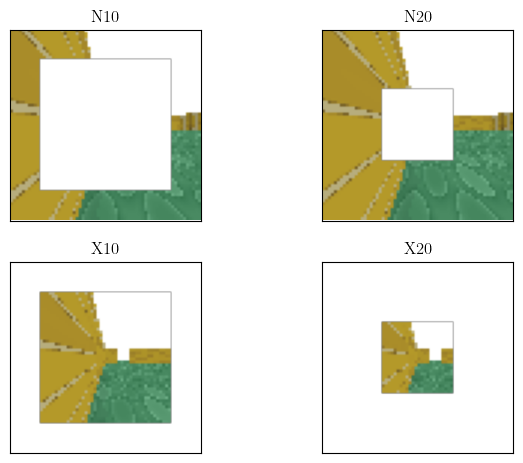

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
dataset = ReachabilityDataset("dataset.hd5", sample_config=SampleConfig())

for sign, axes in zip((-1, +1), axes):
    for norm, axis in zip((10, 20), axes):
        dataset.config.image_crop = sign * norm
        sample, reachable = dataset[0]
        axis.imshow(sample[0].int())
        axis.set_xticks([]); axis.set_yticks([])
        axis.set_title(f"{'N' if sign < 0 else 'X'}{norm}")
plt.savefig('/tmp/image_crops.pgf')

## Visualize dataset

In [5]:
dataset.dataset['positions'].dtype

dtype([('start_observation', '<i4', (16384,)), ('goal_observation', '<i4', (16384,)), ('reached', '?'), ('start', '<f4', (2,)), ('goal', '<f4', (2,)), ('start_orientation', '<f4'), ('goal_orientation', '<f4'), ('start_spikings', '<f4', (9600,)), ('goal_spikings', '<f4', (9600,)), ('start_lidar', '<f4', (52,)), ('goal_lidar', '<f4', (52,))])

In [75]:
print(f"{len(samples)=}")
#some_samples = filter(lambda sample: sample[-1][0] != -1, samples)
#some_samples = filter(lambda sample: sample[2] == False, samples)
some_samples = iter(samples)

len(samples)=10


In [84]:
sample = next(some_samples)
sample, reachable = Sample.from_tuple(sample)

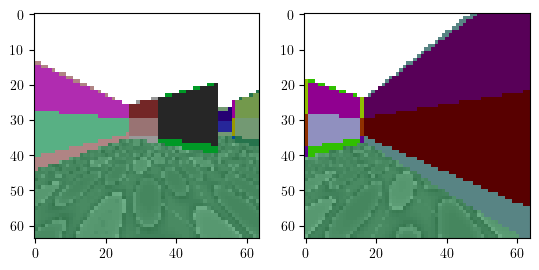

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample.src.img.astype(int))
axes[1].imshow(sample.dst.img.astype(int))

AttributeError: 'list' object has no attribute 'src'

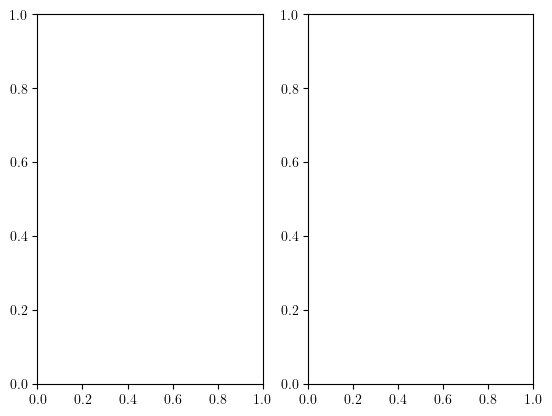

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample.src.img)
axes[1].imshow(sample.dst.img)

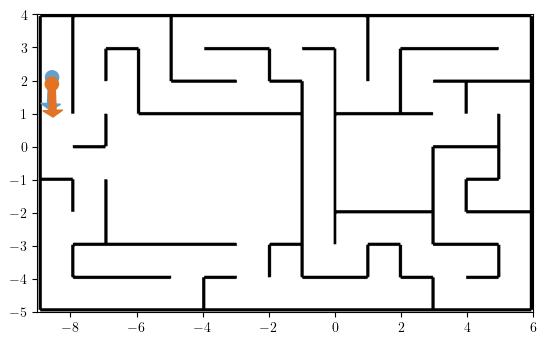

In [9]:
from system.plotting.plotResults import plotStartGoalPair

plotStartGoalPair("Savinov_val3", sample.src.env_coordinates, sample.src.angle, sample.dst.env_coordinates, sample.dst.angle)

In [10]:
print("Reached:", bool(reachable))

Reached: True


In [11]:
from system.plotting.plotThesis import plot_grid_cell_modules
# TODO plot spikings

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


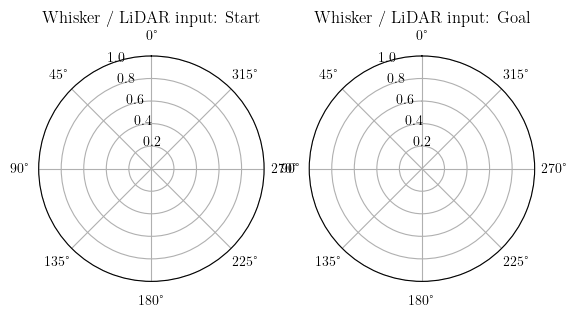

In [12]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})

for ax, lidar, title in zip(axes, [sample.src.lidar, sample.dst.lidar], ['Start', 'Goal']):
    ax.set_theta_zero_location("N")
    ax.scatter(list(lidar.angles), lidar.distances)
    ax.set_rlim(0, 1)

    ax.set_title("Whisker / LiDAR input: " + title)
    print(lidar.distances)
plt.show()

## Some tests

### Train-val split

In [6]:
import torch

In [13]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_size, valid_size

(11200, 2800)

In [37]:
from torch.utils.data import DataLoader, RandomSampler

def reached_percentage(dset, block_size=1000):
    sampler = RandomSampler(dset, True, 1000)
    loader = DataLoader(dset, batch_size=block_size, sampler=sampler, drop_last=True)
    reached = 0
    for batch in loader:
        print(batch)
        reached += sum(batch[1][0])
    return reached/len(dset)

In [38]:
print(f"{reached_percentage(samples):.1%}")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'numpy.void'>

In [30]:
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
print(f"{reached_percentage(train_dataset, block_size=1):.1%=}")
print(f"{reached_percentage(val_dataset, block_size=1):.1%=}")

KeyboardInterrupt: 

### Reachability by distance

In [19]:
block = samples[0:10]
block.dtype
np.linalg.norm(block['goal'] - block['start'], axis=1)

array([0.0982833 , 0.33139315, 0.23023194, 0.24779643, 0.263695  ,
       0.21005335, 0.07857716, 0.02807619, 0.15023497, 0.19408065],
      dtype=float32)

In [37]:
import h5py
import numpy as np
import sys
from tqdm import tqdm

dlength = len(samples)

BLOCK_SIZE=10000
reached_bucket_size = 0.1
arena_size = 8 # empirically
buckets_true = np.zeros(int(arena_size // reached_bucket_size,))
buckets_false = np.zeros_like(buckets_true)
for i in (bar := tqdm(range(0, len(samples), BLOCK_SIZE))):
    actual_block_size = min(BLOCK_SIZE, len(samples) - i)
    block = samples[i:i+actual_block_size]
    distances = np.linalg.norm(block['goal'] - block['start'], axis=1)
    block_true, _ = np.histogram(distances[block['reached']], bins=len(buckets_true), range=(0, arena_size))
    block_false, _ = np.histogram(distances[~block['reached']], bins=len(buckets_true), range=(0, arena_size))
    buckets_true += block_true
    buckets_false += block_false

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


/tmp/ipykernel_3986/4251705996.py:13: RuntimeWarning: invalid value encountered in divide
  axes[1].plot(distances, buckets_true / total_samples, label='Percentage of reachable samples')


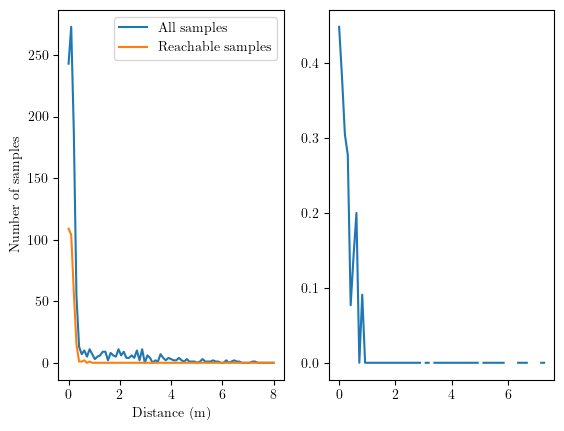

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

total_samples = buckets_true + buckets_false
distances = np.linspace(0, arena_size, len(buckets_true))

axes[0].plot(distances, total_samples, label='All samples')
axes[0].plot(distances, buckets_true, label='Reachable samples')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Number of samples')
axes[0].legend()

axes[1].plot(distances, buckets_true / total_samples, label='Percentage of reachable samples')

# scratchpad

In [4]:
from system.plotting.plotResults import plotStartGoalPair

%psource plotStartGoalPair

def plotStartGoalPair(env_model, start_position, start_heading, target_position, target_heading):
    fig, ax = plt.subplots()
    add_environment(ax, env_model)
    circle = plt.Circle(start_position, 0.2, color=TUM_colors['TUMAccentBlue'], alpha=1)
    ax.add_artist(circle)
    arrow = plt.Arrow(start_position[0], start_position[1], math.cos(start_heading), math.sin(start_heading),
                      color=TUM_colors['TUMAccentBlue'], alpha=1)
    ax.add_artist(arrow)
    circle = plt.Circle(target_position, 0.2, color=TUM_colors['TUMAccentOrange'], alpha=1)
    ax.add_artist(circle)
    arrow = plt.Arrow(target_position[0], target_position[1], math.cos(target_heading), math.sin(target_heading),
                      color=TUM_colors['TUMAccentOrange'], alpha=1)
    ax.add_artist(arrow)
    plt.show()
